<a href="https://colab.research.google.com/github/frank-895/machine_learning_journey/blob/main/random_forests/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.imports import *

# Random Forests on the Spaceship Titanic

Inspired by my recent work on the classic Titanic dataset, I've decided to make a submission to a Kaggle competition called the [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic/data?select=test.csv). The problem is set in 2912 and a group of passengers on an interstellar passenger liner have been launched into alternate dimension. The goal is to use their statistics to determine who has been launched into the alternate dimension!

Since my current area of learning is in **random forests**, I will be limiting myself to this machine learning technique for my submission to demonstrate my learning.

Random forests are machine learning algorithms based on the concept of **ensemble learning**, which combines multiple models to improve performance and reduce overfitting.Random forests are built using multiple **decision trees** and their results are aggregated for more robust and accurate predictions.

## Data Extraction and Cleaning

### Extraction

We can read in our dataset using Pandas, which will be useful for cleaning the data and feature engineering too.

In [ ]:
df = pd.read_csv("train.csv")
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


### Data Cleaning


The first thing to check in our dataframe is for missing values. We can check this easily with Pandas.

In [ ]:
df.isnull().sum()

,0
PassengerId,0
HomePlanet,201
CryoSleep,217
Cabin,199
Destination,182
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208


For the rows with missing values, it would be wasteful to remove them. In order to ensure all the data can be used, I will fill `NaN` values with the mode of the column they exist in. This will ensure the remaining data can be used.

`Transported`, our target variable, does not have any missing values.

In [ ]:
%%capture
for col in df.columns:
  df[col] = df[col].fillna(df[col].mode()[0])

Let's make sure this function worked!

In [ ]:
df.isnull().sum()

,0
PassengerId,0
HomePlanet,0
CryoSleep,0
Cabin,0
Destination,0
Age,0
VIP,0
RoomService,0
FoodCourt,0
ShoppingMall,0


Perfect!

### Feature Engineering

Let's have a look our dataframe and decide what we will do with all our columns and what **feature engineering** we have to perform to feed the data into the random forest.

In [ ]:
df.describe(include='all')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8693,8693,8693,8693,8693.000000,8693,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Alraium Disivering,True
freq,1,4803,5656,207,6097,NaN,8494,NaN,NaN,NaN,NaN,NaN,202,4378
mean,NaN,NaN,NaN,NaN,NaN,28.728517,NaN,220.009318,448.434027,169.572300,304.588865,298.261820,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.355438,NaN,660.519050,1595.790627,598.007164,1125.562559,1134.126417,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,20.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,37.000000,NaN,41.000000,61.000000,22.000000,53.000000,40.000000,NaN,NaN


Here's my action plan for each feature:

- `PassengerId` is unique for each passenger; however, it does contain useful information as it is in the form `gggg_pp` where `gggg` represents the group they are travelling with. Dealing with this value is difficult and there's likely a number of good approaches. I will try transforming this into a binary feature - *whether the passenger is travelling as part of a group or not*.
- `HomePlanet`, `CryoSleep`, `Destination`, `VIP` have unique values between 2-3 so these will be converted to categorical variables without further manipulation.
- `Cabin` is more complex and requires further inspection. It is split into the format `D/N/M` so it may be possible to split this column into 3 separate categorical variables.
- `Age`, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` all represent continuous variables and can be fed directly into the model without further manipulation.
- `Name` is an interesting column. For now, we will dump this column as it will require significant processing to elicit useful information, especially in a random forest. It is possible that the last name could provide valuable insights for the model; however, I theorise that this information will be automatically contained within the `gggg` part of `PassengerId`.

Then finally, `Transported` is our target variable. This represents either 'True' or 'False'.

#### PassengerId

We need to extract the first 4 digits of each value in the `PassengerId` column and convert the value to an integer. Then we can determine if this integer is unique in the column or not, which will be used to determine if the passenger is travelling as part of a group or not.

In [ ]:
def process_passenger_id(df):
  # first 4 digits
  df['with_group'] = [int(i[:4]) for i in df['PassengerId']]
  # determine uniqueness
  df['with_group'] = df['with_group'].map(df['with_group'].value_counts() > 1).astype(int)

process_passenger_id(df)
df['with_group']

,with_group
0,0
1,0
2,1
3,1
4,0
...,...
8688,0
8689,0
8690,0
8691,1


#### Cabin

In [ ]:
df['Cabin'].head()

,Cabin
0,B/0/P
1,F/0/S
2,A/0/S
3,A/0/S
4,F/1/S


For each value in `Cabin` there are three separate pieces of information `deck/num/side`.

Thus, we will split `Cabin` into 3 separate features. `deck` and `side` have a limited number of values and will be **categorical variables**. `num` is a continuous variable and may provide useful information about a person's chance of being in an alternate dimension if it depends on their location in the ship.

In [ ]:
df[['deck', 'num', 'side']] = df['Cabin'].str.split('/', expand=True)
df[['deck', 'num', 'side']]

,deck,num,side
0,B,0,P
1,F,0,S
2,A,0,S
3,A,0,S
4,F,1,S
...,...,...,...
8688,A,98,P
8689,G,1499,S
8690,G,1500,S
8691,E,608,S


Let's make sure that there are no null values - in case the format was not consistent for the data.

In [ ]:
df[['deck', 'num', 'side']].isnull().sum()

,0
deck,0
num,0
side,0


Perfect, now let's confirm that the theorised assignment of categorical and continuous variables was suitable.

In [ ]:
df[['deck', 'num', 'side']].nunique()

,0
deck,8
num,1817
side,2


Seems good! `num` has many unique values, so this will likely be better as a continuous variable.

In [ ]:
df['num'] = df['num'].astype(int)

Now I just need to finish preparing all continuous and categorical variables, since all features have been created.

Let's put all this preprocessing in a function.

In [ ]:
def cabin_process(df):
  df[['deck', 'num', 'side']] = df['Cabin'].str.split('/', expand=True)
  df['num'] = df['num'].astype(int)

#### Categorical Variables

When creating random forests, we don't need to create dummy variables for non-numeric columns, instead just convert them to **categorical variables** with Pandas. Internally, they will be interpreted as numbers.

In [ ]:
categories = ['with_group', 'HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'deck', 'side']
def categorical(df):
  for c in categories:
    df[c] = pd.Categorical(df[c])

categorical(df)
df[categories]

,with_group,HomePlanet,Destination,CryoSleep,VIP,deck,side
0,0,Europa,TRAPPIST-1e,False,False,B,P
1,0,Earth,TRAPPIST-1e,False,False,F,S
2,1,Europa,TRAPPIST-1e,False,True,A,S
3,1,Europa,TRAPPIST-1e,False,False,A,S
4,0,Earth,TRAPPIST-1e,False,False,F,S
...,...,...,...,...,...,...,...
8688,0,Europa,55 Cancri e,False,True,A,P
8689,0,Earth,PSO J318.5-22,True,False,G,S
8690,0,Earth,TRAPPIST-1e,False,False,G,S
8691,1,Europa,55 Cancri e,False,False,E,S


#### Continuous Variables

The continuous variables should be all in numeric format, but we will confirm that and we should be ready!

The great thing about random forests is that we do not need to worry about transforming and normalising continuous variables. Because binary splits (discussed more below) are not dependent on the scale of range of a feature they are **not impacted by outliers**.

In [ ]:
cont = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'num']
df[cont].dtypes

,0
Age,float64
RoomService,float64
FoodCourt,float64
ShoppingMall,float64
Spa,float64
VRDeck,float64
num,int64


#### Finalising

Now, I want to put all of the feature engineering into a single function - this will make it easy to perform on the test set.

In [ ]:
def preprocessing(df):
  # deal with missing values
  for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])

  # deal with passsenger id and cabin columns
  process_passenger_id(df)
  cabin_process(df)

  # mark categorical variables
  categorical(df)

## Creating Model

### Binary Splits

To create the random forest, we will use `scikit-learn` which is a Python library focusing on (generally) classical, not deep learning machine learning techniques.

However, to build our understanding, let's start by building a **binary split**, which predicts our target based only on `CryoSleep`.

> It's important to understand that a random forest is built from a series of **decision trees** and decision trees are built from a series of **binary splits**.

A binary split is where all rows are placed into one of two groups based on their value in some column. With a binary split, we are aiming to use a single feature to split the group based on their target variable.



[Text(0.5, 1.0, 'Histogram')]

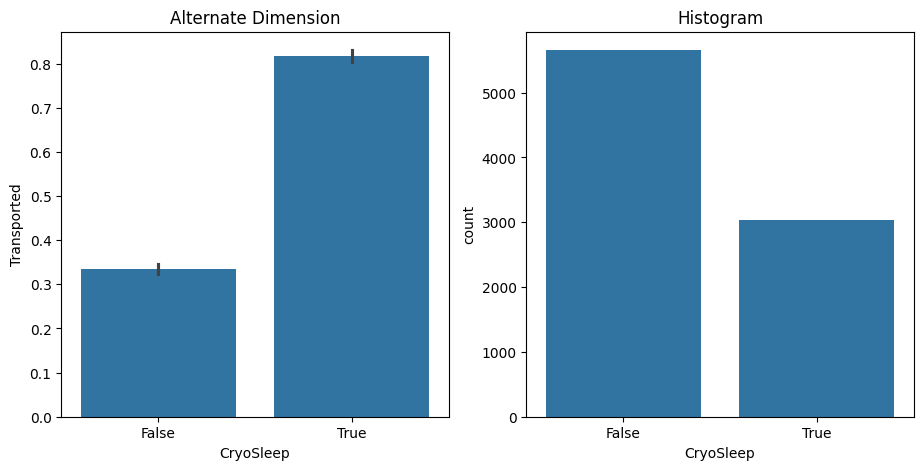

In [ ]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y="Transported", x="CryoSleep", ax=axs[0]).set(title="Alternate Dimension")
sns.countplot(data=df, x="CryoSleep", ax=axs[1]).set(title="Histogram")

We can see that `CryoSleep` is a reasonably good predictor or whether a person was launched into an alternate dimension. People who were in CryoSleep have a much higher chance of being `Transported`.

Let's build a very simple binary split model and see how well we are performing by splitting based on the value of `CryoSleep`.

First, we need to split our data into a training and validation set, which will do using a random split from scikit-learn. We also need to encode all our categorical variables, as we cannot split based on a threshold unless the values are numerical.

In [ ]:
from sklearn.model_selection import train_test_split

trn_df, val_df = train_test_split(df, test_size=0.25) # random split

def xs_y(df):
  """Separates feature columns and the target column"""
  xs = df[categories+cont].copy()
  return xs,df["Transported"] if "Transported" in df else None

trn_df[categories] = trn_df[categories].apply(lambda x: x.cat.codes) # encode categorical variables
val_df[categories] = val_df[categories].apply(lambda x: x.cat.codes) # encode categorical variables

trn_x, trn_y = xs_y(trn_df) # split predictors and target
val_x, val_y = xs_y(val_df) # split predictors and target

Now, we can make our predictions based on whether `CryoSleep` is equal to `0` or not for each row.

In [ ]:
preds = val_x.CryoSleep == 0

from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.7286108555657773

This was a nice try, but we can definitely improve on this score!

We could manually try each variable and find a suitable split point for each, then work out which variable will perform the best binary split; however, it will be much faster and more accurate to automate this!

Instead of using the mean absolute error we will calculate **impurity** - how much the binary split creates two groups where the rows in a group are similar to each other or dissimilar.

In [ ]:
def _side_score(side, y):
  """Calculates a score one side of a split."""
  tot = side.sum() # total number of samples on this side of the split
  if tot <= 1: # a split with very few samples isn't meaningfu
    return 0
  return y[side].std()*tot # selects the target values corresponding with True and computes the std.dev of the target values on this side

def score(col, y, split):
  """Calculates the combined score for a split on col at the value split."""
  lhs = col <= split # creates a boolean mask lhs, where each element is True if the feature is less than or equal to the split threshold
  return (_side_score(lhs, y) + _side_score(~lhs, y)) / len(y) # return the total weighted score and normalizes it by dividing by total number of samples

In [ ]:
def min_col(df, nm):
  """Determines the best split for the feature nm in the dataset df"""
  col, y = df[nm], df["Transported"] # feature values and target values
  unq = col.dropna().unique() # unq will define the unique values (potential split points)
  scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)]) # for each possible split, calculate the score
  idx = scores.argmin() # choose the minimum score for the best split
  return unq[idx], scores[idx] # return the split and corresponding score

In [ ]:
cols = categories + cont # all features
{o:min_col(trn_df, o) for o in cols} # calculate best split for each feature

{'with_group': (0, 0.49687787103052483),
 'HomePlanet': (0, 0.49369197805627746),
 'Destination': (0, 0.4970698138435883),
 'CryoSleep': (0, 0.44452147658329705),
 'VIP': (0, 0.49977907074821915),
 'deck': (2, 0.4924604694707867),
 'side': (0, 0.49740110027125),
 'Age': (6.0, 0.49602883417183485),
 'RoomService': (0.0, 0.46949946967167255),
 'FoodCourt': (0.0, 0.4868389369179063),
 'ShoppingMall': (0.0, 0.48203927195465013),
 'Spa': (0.0, 0.4691757901041471),
 'VRDeck': (0.0, 0.4728771280652429),
 'num': (1186, 0.4987450638148463)}

We've created what is essentially a **OneR classifier**.

It's worth pointing out that the OneR classifier is a fantastic **baseline model**, as it is simple and surprisingly effective. It is a good place to use as a starting point to compare more sophisticated models to.

### Decision Trees

Now that we understand how binary splits work, it is significantly easier to understand **decision trees**. Decision trees are a series of binary splits, that gradually take the data and split into increasingly small subsets. Eventually, the leaf nodes of the decision tree will represent our final predictions.

First, we will define a function to draw the tree, so we can inspect it. This code is courtesy of the following Kaggle notebook I have used for this entire project: [How Random Forests Really Work](https://www.kaggle.com/code/jhoward/how-random-forests-really-work#The-random-forest).

In [ ]:
import graphviz # used to visualise decision trees

def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
  """This function is designed to draw the decision tree"""
  s = export_graphviz(t,
                      out_file=None,
                      feature_names=cols,
                      filled=True,
                      special_characters=True,
                      rotate=True,
                      precision=precision,
                      **kwargs
)
  return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

Now we can import the `DecisionTreeClassifier` from scikit-learn and use it to create a **decision tree**. We use the predefined training data to fit the model, and we can visualise it using our `draw_tree()` function.

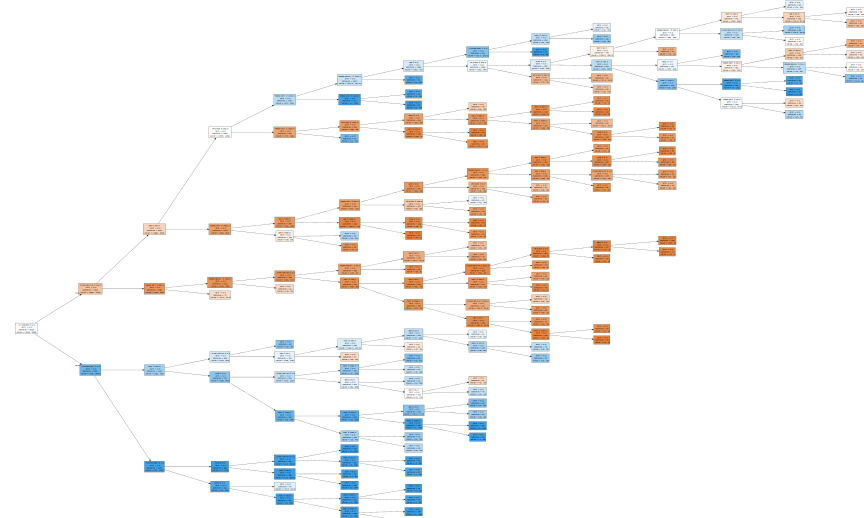

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(min_samples_leaf=50) # creates a decision tree model
m.fit(trn_x, trn_y)
draw_tree(m, trn_x, size=12)

It's very neat how much work scikit-learn can perform in just a few lines of code! Each node shows how many rows (**samples**) match that set of rules and how many values there are in total (**values**). Although, in a strange bug, the **gini scores**, which represents a similar result to the `score()` function, seems to have a bug that I can't work around! The gini scores cannot all be `0` as we can see the split gradually improving as we work towards the leaf nodes.

This appears to just be a bug and we can manually check our **gini scores** below:

In [ ]:
print(m.tree_.impurity)

[0.49998022 0.4465815  0.47964138 0.49999818 0.47492525 0.48663328
 0.49276245 0.39632494 0.4784112  0.49767562 0.42240588 0.
 0.49878759 0.4954601  0.4987152  0.4999446  0.49544602 0.49690696
 0.48052285 0.49956747 0.44444444 0.48113452 0.44938017 0.49980777
 0.38408779 0.47647923 0.49912635 0.32       0.49787877 0.46875
 0.39802289 0.49382716 0.48144096 0.49985636 0.4032     0.38662132
 0.07328798 0.1472     0.         0.49959184 0.48661157 0.4712
 0.42544849 0.39830834 0.4488     0.19753086 0.06603843 0.1472
 0.         0.34588233 0.27978248 0.32566893 0.47480217 0.25369392
 0.14090779 0.21875    0.06243496 0.30925606 0.43307555 0.1904058
 0.11550296 0.26592798 0.09972299 0.         0.15444912 0.34567901
 0.31815445 0.26106932 0.3029079  0.26071171 0.22789573 0.15879017
 0.26977041 0.12327038 0.05876951 0.18325698 0.2935627  0.3372821
 0.25765102 0.40816327 0.2055165  0.38178604 0.44444444 0.2862426
 0.4632719  0.49861496 0.2952     0.07096953 0.12335351 0.03702385
 0.2007832  0.   

This confirms that the `0` gini scores are indeed a bug with the tree printing mechanism, as the model is correctly calculating non-zero gini scores.

> The gini score represents the probability that, if you pick two rows from a group, you'll get the same `Transported` result each time. If the group is all the same, the probability is `1` and if the group is all different you'll get a score of `0.0`.  

We will use the same `mean_absolute_error()` function we used before to evaluate our decision tree's predictions on the **validation set**.

In [ ]:
mean_absolute_error(val_y, m.predict(val_x))

0.21527138914443422

Not a bad effort and this is performing significantly better than our OneR classifier. I will try submitting this lone decision tree to Kaggle!

In [ ]:
%%capture
# extract test features
test_df = pd.read_csv("test.csv")

# perform preprocessing and encoding
preprocessing(test_df)
test_df[categories] = test_df[categories].apply(lambda x: x.cat.codes)

# extract features
tst_x,_ = xs_y(test_df)

test_df['Transported'] = m.predict(tst_x) # make predictions using DecisionTree model
sub_df = test_df[['PassengerId', 'Transported']] # extract relevant columns

In [ ]:
sub_df.to_csv('submission.csv', index=False)

With this single deicision tree, my **accuracy** on the test dataset was 0.784 but only scoring in the top 75% of submissions! We will attempt improve on this model by creating a **random forest**.

### Random Forests

**Random forests** make use of a technique called **bagging**, which is where you take the average prediction of a bunch of models.

The idea is that we want each model's predictions in the averaged **ensemble** of models to be uncorrelated. Then, the average of the predictions will converge to the true target value! This is a very cool observation and it means that random forests are immune to overfitting - they are assymptotic, in that they converge to the true value.

> This discovery relies on an import principle - the average of lots of uncorrelated random errors is **zero**.

One way we can get a bunch of uncorrelated models is to train each of them on a different subset of data.

In [ ]:
def get_tree(prop=0.75):
  """Creates a decision tree using a subset of data of a size defined by prop."""
  n = len(trn_y)
  idxs = np.random.choice(n, int(n*prop))
  return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_x.iloc[idxs], trn_y.iloc[idxs])

Since we have a function that will create a single tree with a random subset of data, let's try creating 100 trees!

In [ ]:
trees = [get_tree() for _ in range(200)]

Now, we can take the average of these predictions, using Numpy for C optimised code.

In [ ]:
all_probs = [t.predict(val_x) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.24754599816007358

Ok, our model is actually performing slightly worse than the single decision tree. That's because our manual **random forest** is missing an important feature - when scikit-learn's `RandomForestClassifier` chooses a random subset of data, it also picks a random subset of features, making the predictions completely uncorrelated!

Let's use the predefined random forest model to boost our prediction!

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(200, min_samples_leaf=3)
rf.fit(trn_x, trn_y);
mean_absolute_error(val_y, rf.predict(val_x))

0.1812327506899724

Now we're talking! We've reduced the minimum size of our leaf nodes to really maximise our preditive power and increased the number of decision trees - why not? There's no risk of overfitting!

This result has improved our lone decision tree approach and we can now submit to Kaggle!

In [ ]:
test_df['Transported'] = rf.predict(tst_x)
sub_df = test_df[['PassengerId', 'Transported']]

sub_df.to_csv('submission.csv', index=False)

Our final accuracy result on Kaggle with the test data was 0.797, which put the result in the top 35% at the time! When submitting the single decision tree our result only came in the top 75%!

While our result does not make the absolute best predictions compared to a deep learning approach (in this situation but not necessarily all the time!), it has got one extra advantage. We can use our random forest generated by sklearn to plot the importance of the features by how often the model used the feature to split the data.

<Axes: ylabel='cols'>

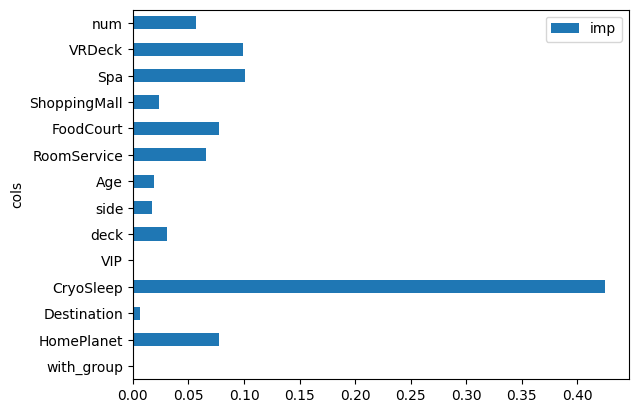

In [ ]:
pd.DataFrame(dict(cols=trn_x.columns, imp=m.feature_importances_)).plot('cols','imp','barh')

This graph demonstrates the real power of the **random forest**. As suspected by our single binary split, `CryoSleep` is by far the most important predictor. We can also see which predictors weren't so important, such as `VIP`, `Destination` and `with_group`. If we were working with a dataset that had thousands of features, random forests are extremely useful in quickly sorting through the data to find the most important variables. Then, we can focus our efforts on collecting, analysing and feature engineering with the most important predictors. This also allows us to save time if we are producing a deep learning model, as we can immediately discard variables, reducing training time.

> **It is important to note that random forests run much faster than a deep learning model.**

## Conclusion

In this notebook, as well as learning the core fundamentals of **random forests** we've made some important fundamentals.

Firstly, random forests/binary splits/decision trees can be fantastic benchmark models. You may find that these models provide all the accuracy you need, and if not, they can help you sort through the features to make deep learning more efficient!

Secondly, random forests are not complicated and very hard to mess up! Unlike other regression tasks or deep learning, it is very easy to overfit to the training data or even to the validation set! You have to worry about normalizations and non-linear transformations - all of which the random forest handles on its own. This makes it a powerful and quick model to try out before moving to something more complicated (and easy to mess up!).

Thanks for reading my notebook that provides a bit of insight into my learning journey with random forests. I would like to reiterate that the code and notes represent my learnings but have been sourced from [How Random Forests Really Work](https://www.kaggle.com/code/jhoward/how-random-forests-really-work#The-random-forest). I've used a separate dataset to demonstrate my learning!